# satCORPS composite Sketch #3 STARE Sorted Subsetting

![Subsetting STARE-sorted format data](2022-0519-STARE-sorted-ScatterPlot-Resolution\=11.jpg)


In [1]:
import pystare
import starepandas
import geopandas
import pandas

import numpy
from netCDF4 import Dataset
import matplotlib.pyplot as plt
import cartopy
import cartopy.crs as ccrs

import pystareplotlib
import pystareplotlib.pystareplotlib as psplot

import datetime

import pickle

import regionmask
import xarray
from shapely.geometry import Polygon

import dask

plot_options = {'projection': ccrs.PlateCarree(central_longitude=0.0)
                ,'transform': ccrs.Geodetic()}

In [2]:
class timings_store:
    def __init__(self):
        self.timings = {}
        return
   
    def add(self,key,value,verbose=True):
        self.timings[key] = value
        if verbose:
            print("{} {}".format(key,value))
        return self
    
    def print_report(self,fmt="{:30} {:>6.2f}",key=None,grepv=None):
        for i, (k,v) in enumerate(self.timings.items()):
            if key is None:
                if not grepv is None:
                    if not grepv in k:
                        print(fmt.format(k,v.total_seconds()))
                else:
                    print(fmt.format(k,v.total_seconds()))
            else:
                if key in k:
                    if not grepv is None:
                        if not grepv in k:
                            print(fmt.format(k,v.total_seconds()))
                    else:
                        print(fmt.format(k,v.total_seconds()))
        return self
    
timings = timings_store()

# timings.print_report(fmt="{:70} {:>6.2f}")

## Define our prototype STARE-sorted format data loader

In [3]:
# take the intersection, get the level, coerce to it, then uniquify, then loop, load, and concat.

class chunk_lite:
    def __init__(self,start,stop):
        self.start = start
        self.stop  = stop
        return
    
def read_hdf(data_filename,sids,pods_map_filename):
    pods_map_filename = 'pods_map.pkl' if pods_map_filename is None else pods_map_filename
    
    start1 = datetime.datetime.now()
    with open( pods_map_filename, 'rb' ) as f:
        pods_lite = pickle.load(f)
    timings.add('time to load pods map',datetime.datetime.now() - start1)
    
    resolution = int(pystare.spatial_resolution(list(pods_lite.keys())[0]))
    
    idx = numpy.unique(
        pystare.spatial_clear_to_resolution(
            pystare.spatial_coerce_resolution(pystare.expand_intervals(sids,resolution),resolution)))
                                              
    # print(idx)
    dfs = []
    for s in idx:
        chunk = pods_lite[s]
        df = pandas.read_hdf(data_filename,start=chunk.start+2,stop=chunk.stop)
        dfs.append(df)
        
    return pandas.concat(dfs)

## Load the ROI

In [4]:
start0 = datetime.datetime.now()
with open( 'ROI.pkl', 'rb' ) as f:
    roi = pickle.load(f)
timings.add('time to load ROI',datetime.datetime.now() - start0)

time to load ROI 0:00:00.091947


## Use the ROI to load data from the sorted STARE-format data file

- Optionally coarsen the resolution of the ROI

In [5]:
start0 = datetime.datetime.now()

# i = 90
# chunk = pods_lite[keys[i]]
# df = pandas.read_hdf('composite.h5',start=chunk.start+2,stop=chunk.stop)

# bdf = states[states.NAME=='Hawaii']
# b = states[states.NAME=='Hawaii']['sids'].iloc[0]

b = roi['sids'].iloc[:].to_numpy().copy()

# Set resolution of ROI to load
if False:
    resolution = 7
    b[ (b & 31) > resolution ] = \
        pystare.spatial_clear_to_resolution(
            ( b[ (b & 31) > resolution ] & ~31 ) | resolution )
    b = numpy.unique(b)

df = starepandas.STAREDataFrame(read_hdf('composite.h5',b,'pods_map.pkl')).reset_index()
c = df.stare_intersects(b,n_workers=50)
df = df[c]

timings.add('time to open/read and subset data from stare-sorted format',datetime.datetime.now() - start0)

time to load pods map 0:00:00.017417
time to open/read and subset data from stare-sorted format 0:00:09.756050


## Take a look at the data loaded

In [6]:
plot_options = {'projection': ccrs.PlateCarree(central_longitude=0.0)
                ,'transform': ccrs.Geodetic()}
plot_options['projection']._threshold = 0.01

In [7]:
if False:
    usr_figax = psplot.FigAxContainer(
        plt.subplots(figsize=(4,4), dpi=400
                            ,subplot_kw=plot_options))

    usr_figax.ax.gridlines(linewidth=0.1)
    usr_figax.ax.set_global()
    usr_figax.ax.coastlines(linewidth=0.1)

    usr_figax, sivs_cache, sivs_triang = psplot.hello_plot(b,usr_figax,rasterized=True,plot_options=plot_options)
    del usr_figax, sivs_cache, sivs_triang

time to start plot 0:00:00.244263


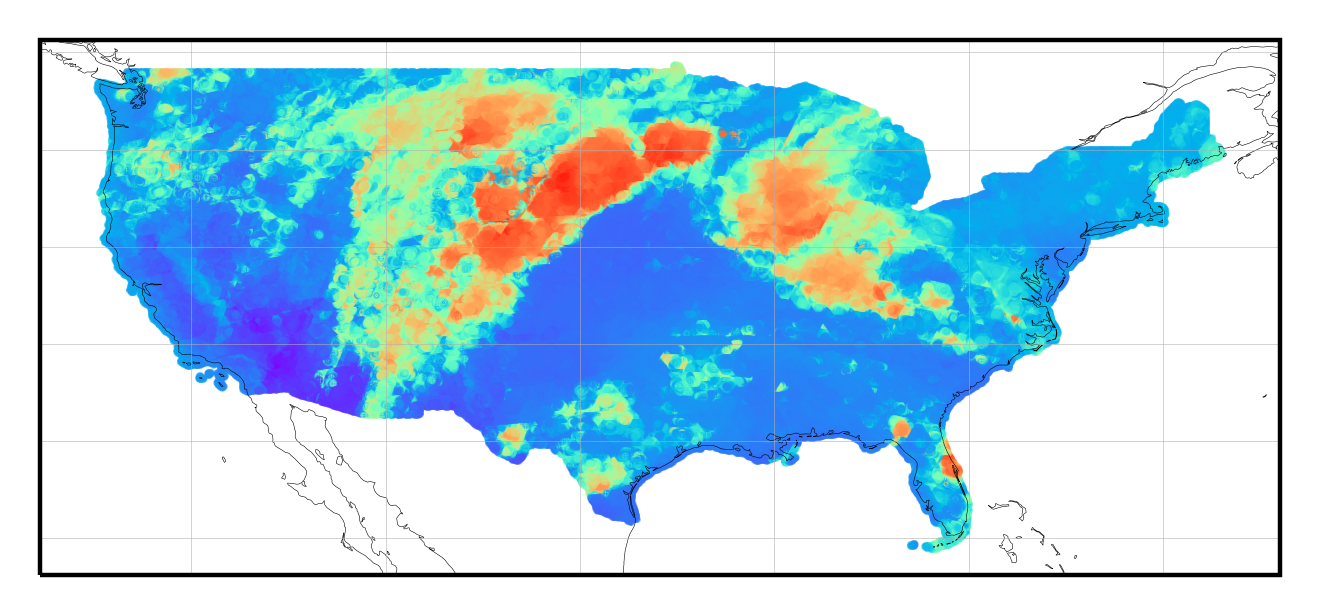

In [8]:
start0 = datetime.datetime.now()

usr_figax = psplot.FigAxContainer(
    plt.subplots(figsize=(4,4), dpi=400
                 ,subplot_kw=plot_options))

ax = usr_figax.ax

usr_figax.ax.gridlines(linewidth=0.1)
# usr_figax.ax.set_global()
usr_figax.ax.coastlines(linewidth=0.1)

if False:
    # x0 = 166; y0 = -15; dlim = 0.5
    # x0 = 165.5; y0 = -17.5; dlim = 3.75
    # dlimx = dlim; dlimy = dlim
    x0 = -127; y0 = 24; dlimx = 61; dlimy = 27
    
    ax.set_xlim(x0,x0+dlimx)
    ax.set_ylim(y0,y0+dlimy)

    marker_size=40.0/(dlim**2) # good for 'o'
    marker_size=27.0/(dlim**2) # good for 's'
    marker_alpha=0.5
else:
    ax.set_aspect('equal')
    marker_size=0.01
    marker_alpha=0.5
    
marker='s'

# df.plot(ax=ax,column='map_data/BT_12.0m',zorder=1,cmap='OrRd',trixels=True)
# df.plot(ax=ax,zorder=1,color='red',trixels=False,boundary=True)

# Doesn't work for 1-D data
# ax.contourf(df['lons'],df['lats'],df['BT_12_0um']
#            ,cmap='nipy_spectral'
#            ,cmap='rainbow'
#            ,transform=ccrs.PlateCarree()
#        )
if True:
    usr_figax.ax.scatter(df['lons'],df['lats']
                ,s=marker_size
                ,c=df['BT_12_0um']
                ,alpha=marker_alpha
    #            ,cmap='nipy_spectral'
                ,cmap='rainbow_r'
                ,marker=marker
                ,rasterized=True
                ,transform=ccrs.PlateCarree()
                )

    
    
# bdf = starepandas.STAREDataFrame(sids=b,add_trixels=True)
# bdf.plot(
#     ax=ax
#     ,trixels=True, boundary=True, color='y', zorder=1, linewidth=0.5
#     ,transform=ccrs.PlateCarree()
# )

if False:
    usr_figax, sivs_cache, sivs_triang = psplot.hello_plot(b,usr_figax
                                                            ,rasterized=True
                                                            ,face_edgecolors='r'
                                                          )
    del sivs_cache, sivs_triang

# plt.scatter(df['lons'],jdf1['lats'],s=marker_size,color='k',alpha=marker_alpha)
# plt.scatter(df['lons'],jdf1['lats'],s=marker_size,color='k',alpha=marker_alpha)

if False:
    # bdf.plot(ax=ax, trixels=True, boundary=True, color='k', zorder=1, linewidth=0.25)
    roi.plot(ax=ax, trixels=True, boundary=True, color='k', zorder=1, linewidth=0.5)
    
if False:
    conus1.plot(ax=ax, trixels=False, facecolor="none", edgecolor='yellow', zorder=1, linewidth=1.5)
    
del usr_figax, ax

timings.add('time to start plot',datetime.datetime.now()-start0)

In [9]:
timings.add('total time to read & render',datetime.datetime.now() - start0)

total time to read & render 0:00:10.478195


## Timing summary report

In [10]:
timings.print_report(fmt="{:70} {:>6.2f}")

time to load ROI                                                         0.09
time to load pods map                                                    0.02
time to open/read and subset data from stare-sorted format               9.76
time to start plot                                                       0.24
total time to read & render                                             10.48
